# Introduction

First submission :

<a href='#1'>1. Loading Data</a>

<a href='#2'>2. Combining Datasets</a>

<a href='#3'>3. Memory Limitation</a>

<a href='#4'>4. Missing Values</a>

<a href='#5'>5.EDA</a>

<a href='#6'>6. Model Training</a>

<a href='#7'>7. Model Predictions and Kaggle Submission</a>

# <a id='1'>1. Loading Data</a>

In [36]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sn
import statistics

In [37]:
#load data
train = pd.read_csv('kaggle/input/ashrae-energy-prediction/train.csv')
train['timestamp'] = pd.to_datetime(train['timestamp']) #the train dataset contains a 'timestamp' column we convert to a datetime object for ease of use
test = pd.read_csv('kaggle/input/ashrae-energy-prediction/test.csv')
test['timestamp'] = pd.to_datetime(test['timestamp'])
weather_train = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_train.csv')
weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test = pd.read_csv('kaggle/input/ashrae-energy-prediction/weather_test.csv')
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp']) 
build_meta = pd.read_csv('kaggle/input/ashrae-energy-prediction/building_metadata.csv')

In [38]:
train.shape

(20216100, 4)

In [39]:
test.shape

(41697600, 4)

For a simple first model, we are going to merge the training sets to gather all covariables and make predictions on it with a linear regressor.

# <a id='2'>2. Combining Datasets</a>
We will merge everything into train and test dataframes.

We need to convert the timestamp to the right type:

In [40]:
weather_test.timestamp = pd.to_datetime(weather_test.timestamp) 
weather_train.timestamp = pd.to_datetime(weather_train.timestamp) 

In [41]:
#merge the building meta data and weather data into the train data
train_m = train.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
test_m = test.merge(build_meta, how='left', on = ['building_id'], validate='many_to_one') #merge the building meta data into the train data
train_m = train_m.merge(weather_train, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
test_m = test_m.merge(weather_test, how='left', on = ['site_id', 'timestamp'], validate='many_to_one')#add weather data to each time entry for each site ID
del build_meta, weather_train, weather_test
import gc
gc.collect() #mandatory since we don't have unlimited space (16go and the databases are quite large)
train_m.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


# <a id='3'>3. Memory Limitation</a>

In [42]:
def reduce_mem_usage(df, verbose=True): #we need to drastically reduce memory usage to work with those data basis
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

train_m = reduce_mem_usage(train_m) #this code changes the variable formats so it takes less space
test_m = reduce_mem_usage(test_m) #source for this code : https://www.kaggle.com/alexandersylvester/ashrae-energy-predictions-with-lightgbm

Mem. usage decreased to 1041.10 Mb (60.3% reduction)
Mem. usage decreased to 2147.36 Mb (60.3% reduction)


# <a id='4'>4. Missing Values</a>

/!\ ne pas executer la partie 4, la partie 5 traite ce sujet de manière plus complète

In [ ]:
test_m.isna().describe()

The easy way out in this scenario is to drop the columns containing any NA. Which we're going to do for the time being. We have no missing value for the target variable so we will not be dropping any training row

In [ ]:
train_m = train_m.dropna(axis='columns')

In [ ]:
gc.collect(generation=0)
gc.collect(generation=1)
gc.collect() #supposedly cleans the memory but not that efficient // we need a better way

In [ ]:
test_m = test_m.dropna(axis='columns')

In [ ]:
train_m.describe()

In [ ]:
test_m.describe()

In [ ]:
train_m.groupby("primary_use").sum()

In [ ]:
train_m.primary_use = train_m.primary_use.astype('category')
test_m.primary_use = test_m.primary_use.astype('category')

In [ ]:
# dr = test_m.primary_use
# test_m = test_m.drop('primary_use',axis=1)

In [ ]:
# dr2 = train_m.primary_use
# train_m = train_m.drop('primary_use',axis=1)
## train_m = train_m.drop('meter_reading',axis=1)

In [ ]:
test_m.dtypes

In [ ]:
train_m.dtypes

In [ ]:
train_df = train_m
test_df = test_m

In [ ]:
import math

train_df['month_datetime'] = train_df['timestamp'].dt.month.astype(np.int8)
train_df['weekofyear_datetime'] = train_df['timestamp'].dt.weekofyear.astype(np.int8)
train_df['dayofyear_datetime'] = train_df['timestamp'].dt.dayofyear.astype(np.int16)
    
train_df['hour_datetime'] = train_df['timestamp'].dt.hour.astype(np.int8)  
train_df['day_week'] = train_df['timestamp'].dt.dayofweek.astype(np.int8)
train_df['day_month_datetime'] = train_df['timestamp'].dt.day.astype(np.int8)
train_df['week_month_datetime'] = train_df['timestamp'].dt.day/7
train_df['week_month_datetime'] = train_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)
    
# train_df['year_built'] = train_df['year_built']-1900
train_df['square_feet'] = np.log(train_df['square_feet'])
    
test_df['month_datetime'] = test_df['timestamp'].dt.month.astype(np.int8)
test_df['weekofyear_datetime'] = test_df['timestamp'].dt.weekofyear.astype(np.int8)
test_df['dayofyear_datetime'] = test_df['timestamp'].dt.dayofyear.astype(np.int16)
    
test_df['hour_datetime'] = test_df['timestamp'].dt.hour.astype(np.int8)
test_df['day_week'] = test_df['timestamp'].dt.dayofweek.astype(np.int8)
test_df['day_month_datetime'] = test_df['timestamp'].dt.day.astype(np.int8)
test_df['week_month_datetime'] = test_df['timestamp'].dt.day/7
test_df['week_month_datetime'] = test_df['week_month_datetime'].apply(lambda x: math.ceil(x)).astype(np.int8)

# <a id='5'>5. EDA</a>

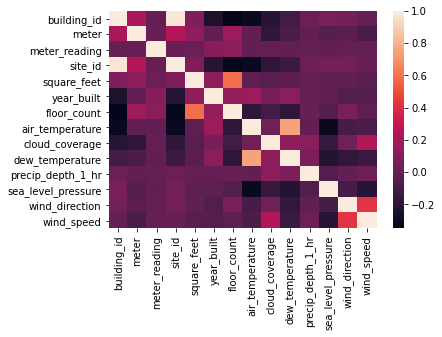

In [47]:
mat_coorr=train_m.corr()
sn.heatmap(mat_coorr)
plt.show()

Pas de corrélation particulière entre `meter_reading` et les autres variables. Il y a cependant quelques corrélations entre certaines variables comme `floor_count` et `square_feet` ou `air_temperature` et `dew_temperature`. nous les traiterons plus tard pour voir si ces corrélations ont une influence sur nos modèles. 

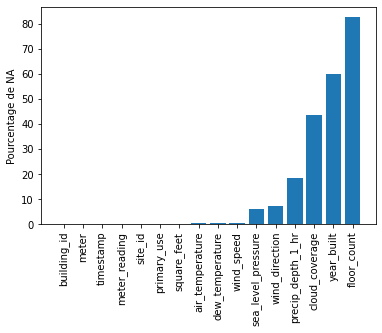

In [48]:
is_na=train_m.isnull().sum()*100/train_m.shape[0]
is_na=is_na.sort_values()
ind = np.arange(len(is_na))
plt.bar(ind, is_na.values)
plt.xticks(ind,is_na.index,rotation=90)
plt.ylabel("Pourcentage de NA")
plt.show()

Les labels `floor_count` et `year_built` sont ceux pour lesquels il y a le plus de NA. C'est dommage car ce sont des indexs qui intuitivement auront beaucoup d'influence sur l'energie consommée.

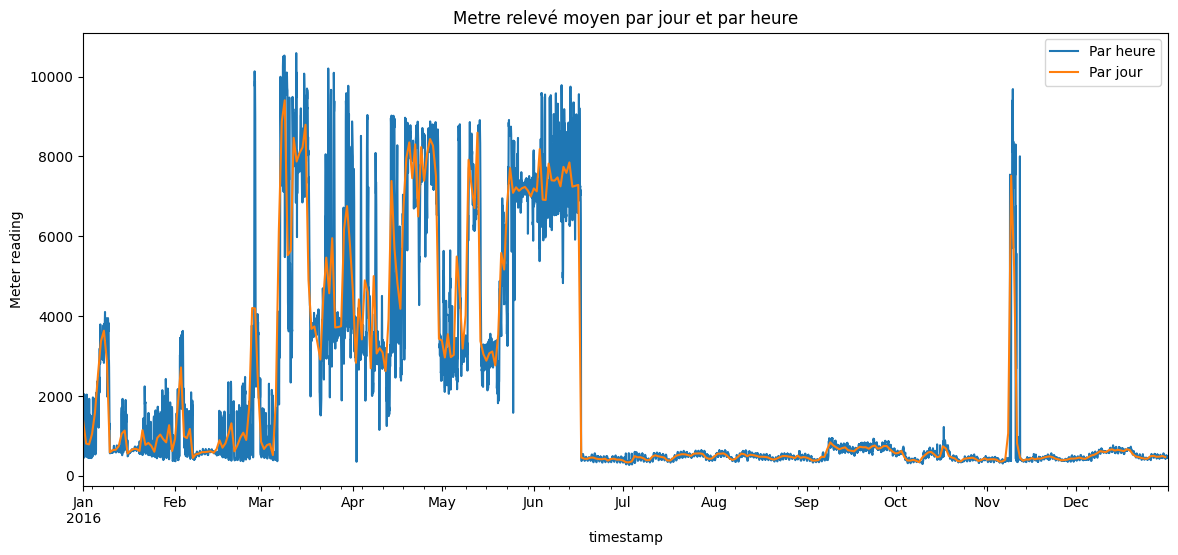

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

La forme de la distribution de la valeur cible dans le temps est plutôt étrange. On observe des pics irréguliers. Regardons de plus près.

In [11]:
import warnings
warnings.filterwarnings("ignore")

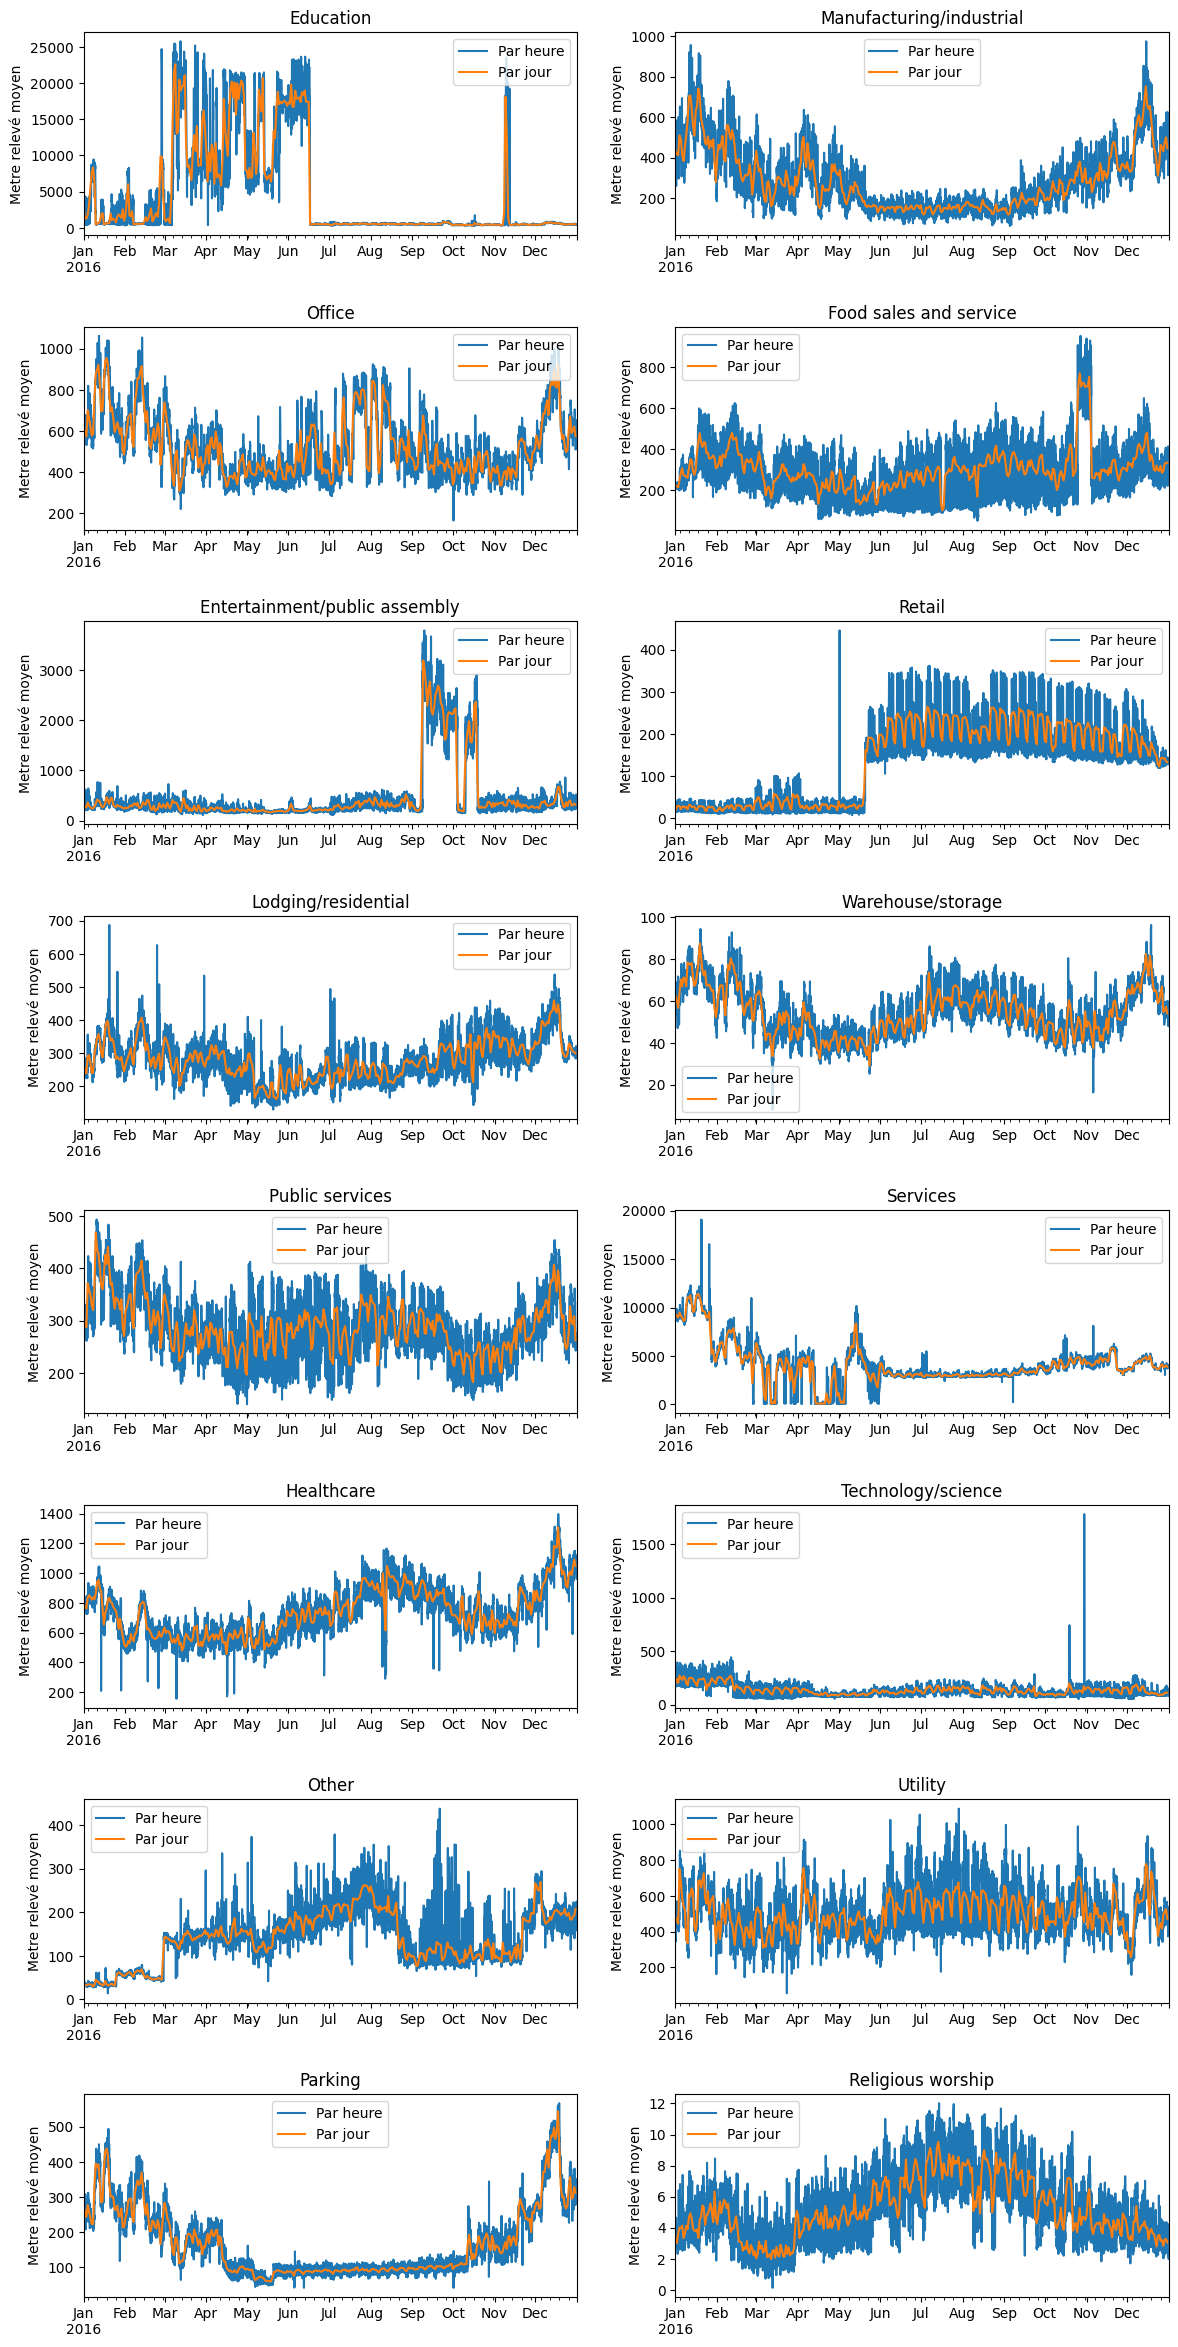

In [12]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_pu=list(train_m['primary_use'].value_counts().index);
for i in range(len(list_pu)):
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
    train_m[train_m['primary_use'] == list_pu[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
    axes[i%8][i//8].legend();
    axes[i%8][i//8].set_title(list_pu[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()

Notre problème se situe dans Education.

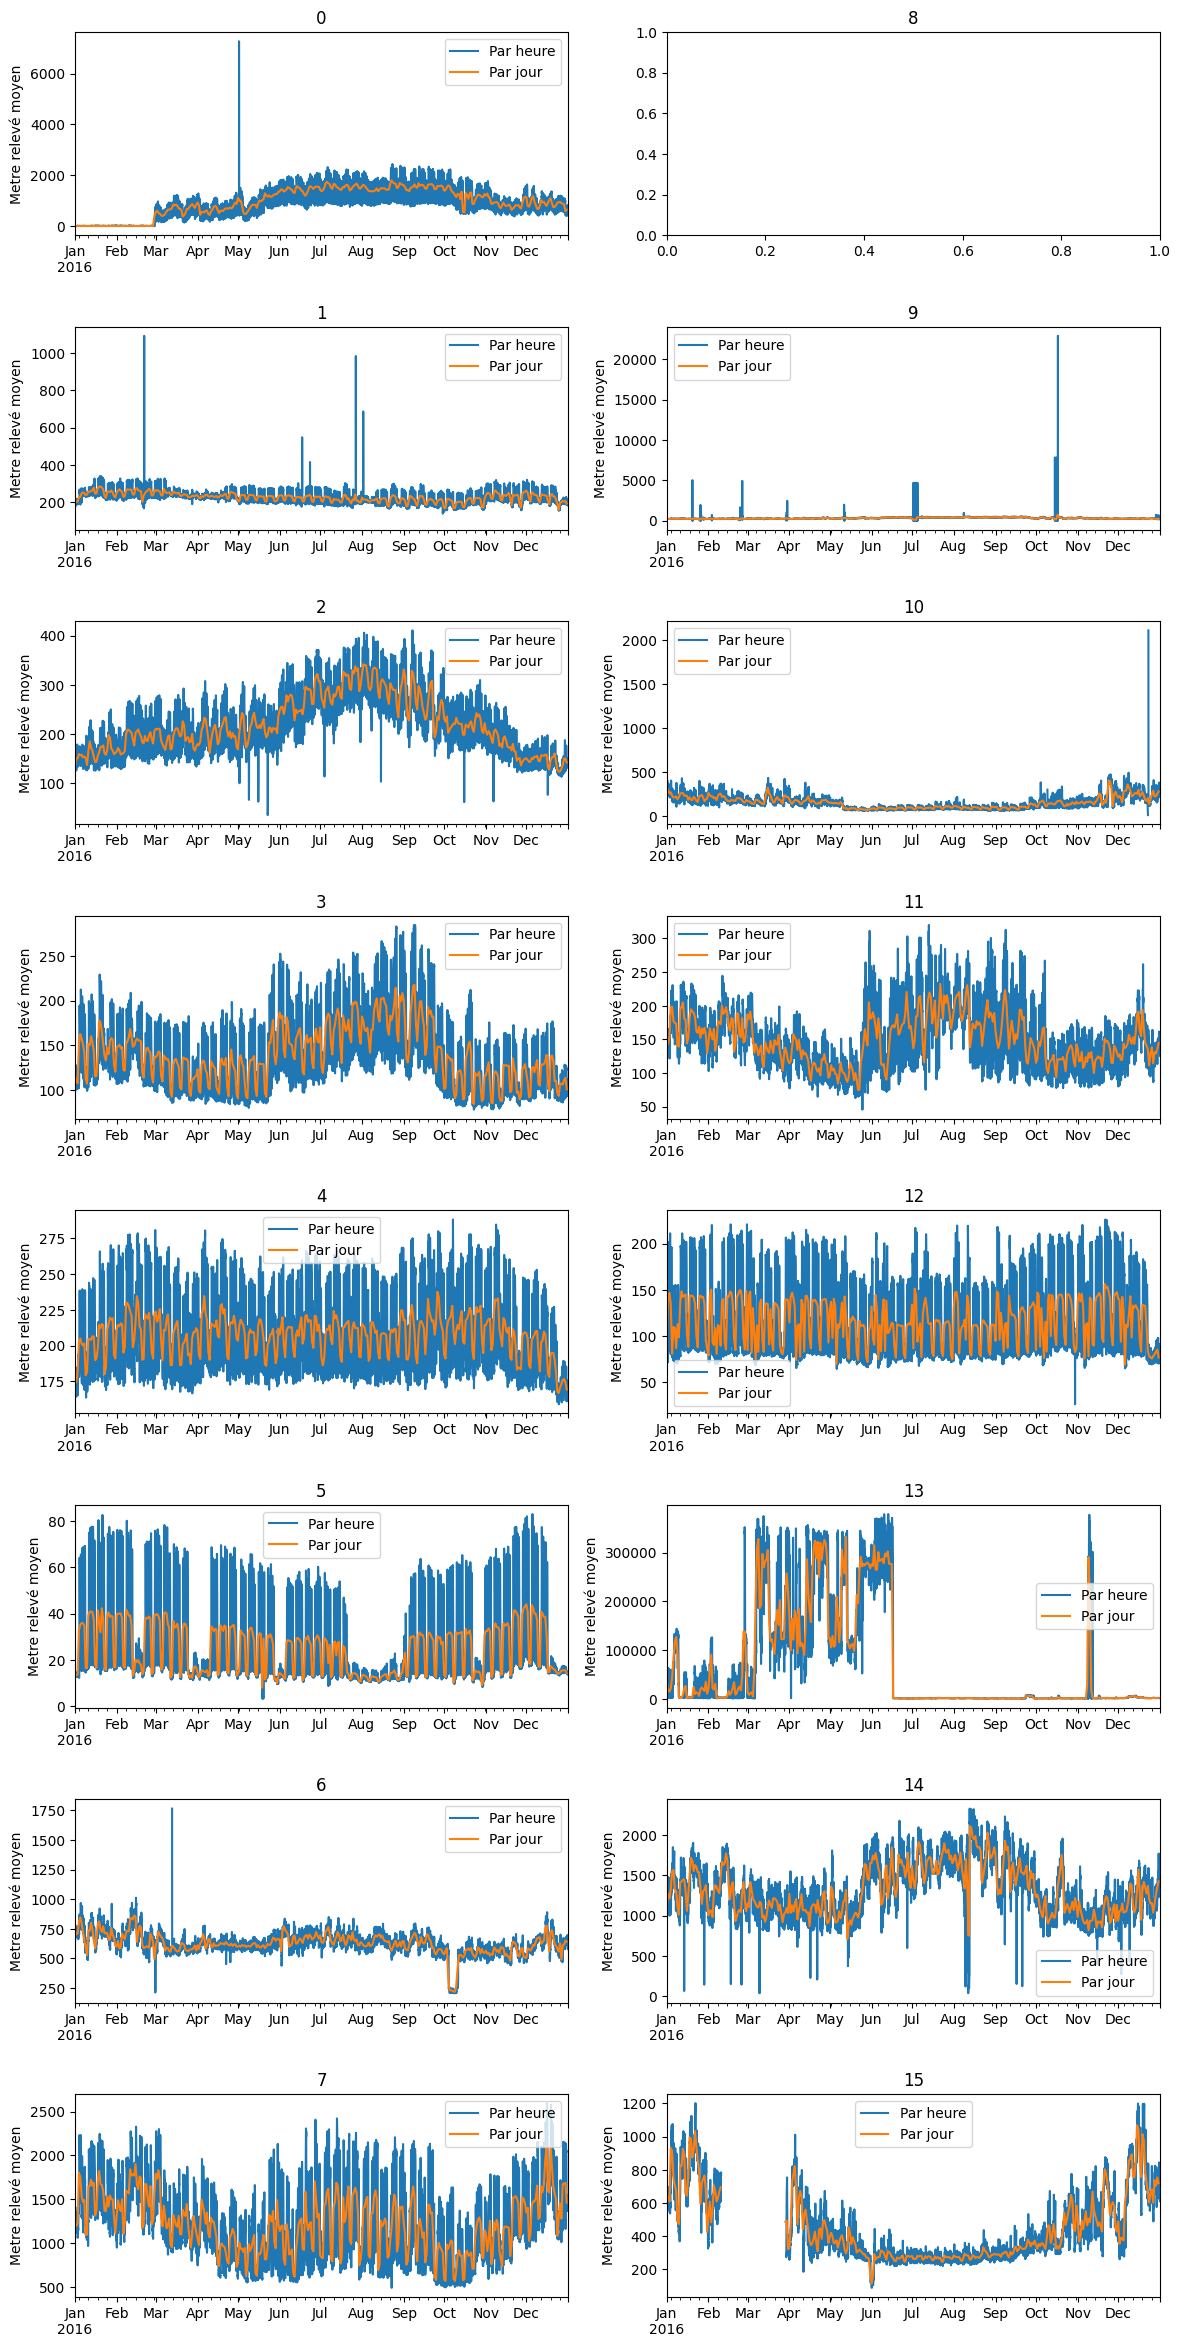

In [13]:
fig, axes = plt.subplots(8,2,figsize=(14, 30), dpi=100)
list_sid=list(train_m['site_id'].value_counts().index);
train_hist=train_m[train_m['primary_use'] == 'Education']
for i in range(len(list_sid)):
    try :
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%8][i//8], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist[train_hist['site_id'] == i][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%8][i//8],  label='Par jour').set_xlabel('');
        axes[i%8][i//8].legend();
    except :
        pass
    axes[i%8][i//8].set_title(i);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;

Notre problème se situe dans le 13.

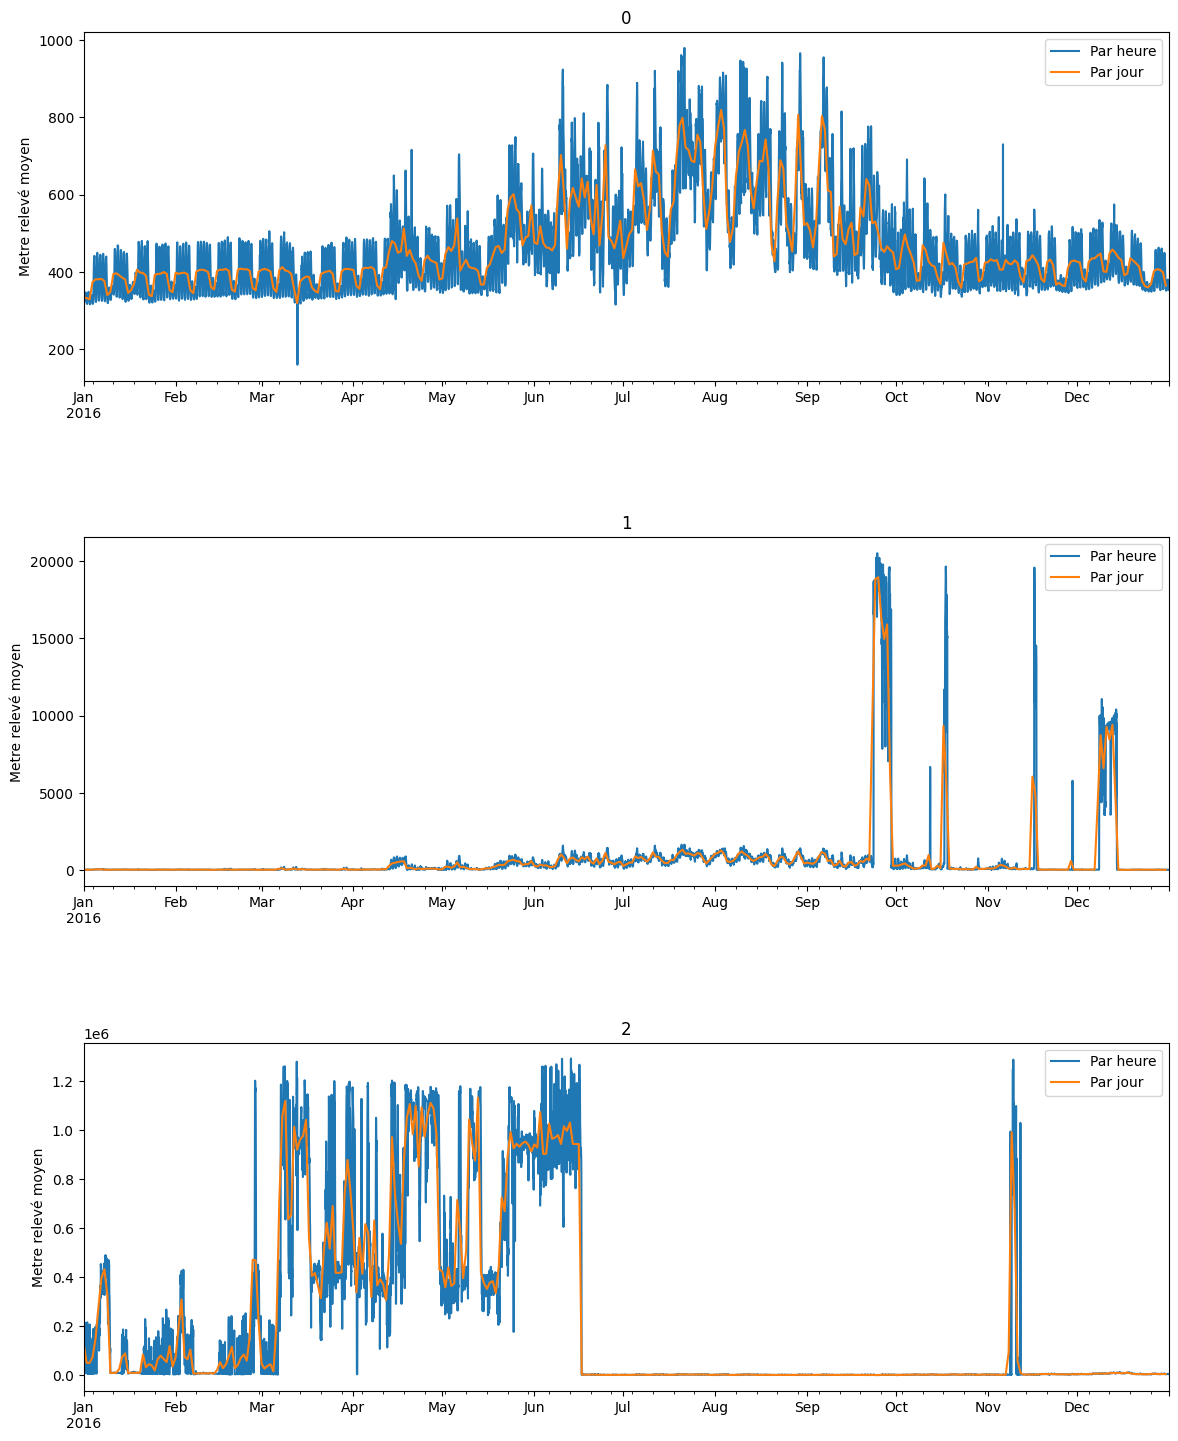

In [14]:
fig, axes = plt.subplots(3,1,figsize=(14, 18), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
list_met=list(train_hist2['meter'].value_counts().index);
for i in range(len(list_met)):
    try :
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist2[train_hist2['meter'] == list_met[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i],  label='Par jour').set_xlabel('');
        axes[i].legend();
    except TypeError:
        pass
    axes[i].set_title(list_met[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;

Le problème se situe dans le metre de type 2.

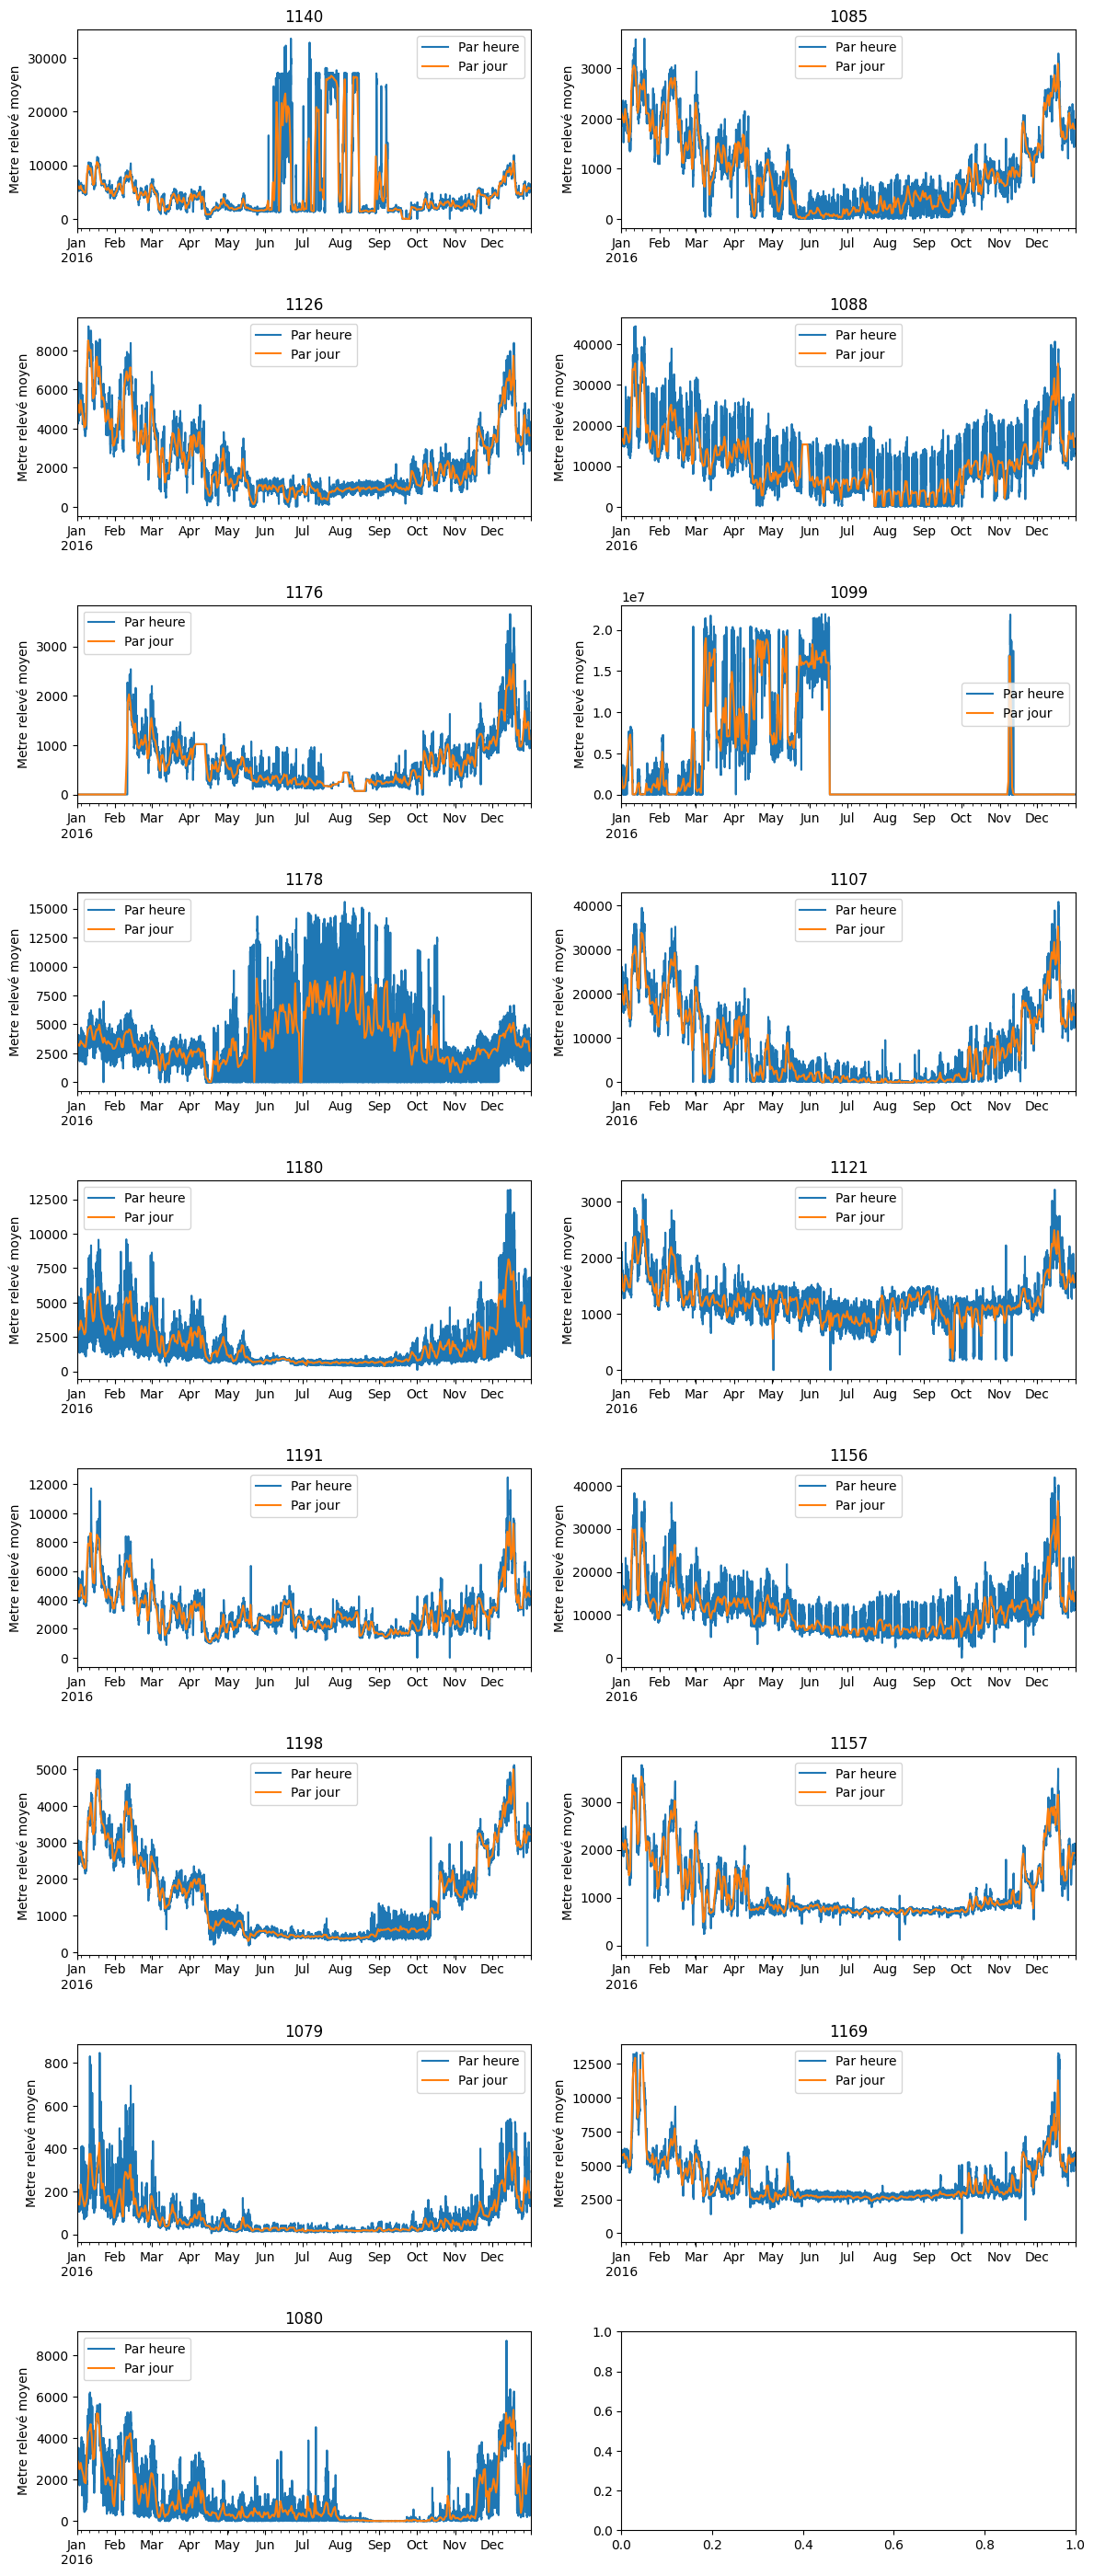

In [15]:
fig, axes = plt.subplots(9,2,figsize=(14, 36), dpi=100)
train_hist=train_m[train_m['primary_use'] == 'Education']
train_hist2=train_hist[train_hist['site_id'] == 13]
train_hist3=train_hist2[train_hist2['meter']==2]
list_build=list(train_hist3['building_id'].value_counts().index);
for i in range(len(list_build)):
    try :
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes[i%9][i//9], label='Par heure').set_ylabel('Metre relevé moyen');
        train_hist3[train_hist3['building_id'] == list_build[i]][['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes[i%9][i//9],  label='Par jour').set_xlabel('');
        axes[i%9][i//9].legend();
    except TypeError:
        pass
    axes[i%9][i//9].set_title(list_build[i]);
    plt.subplots_adjust(hspace=0.45)
plt.show()
del train_hist;
del train_hist2;
del train_hist3;

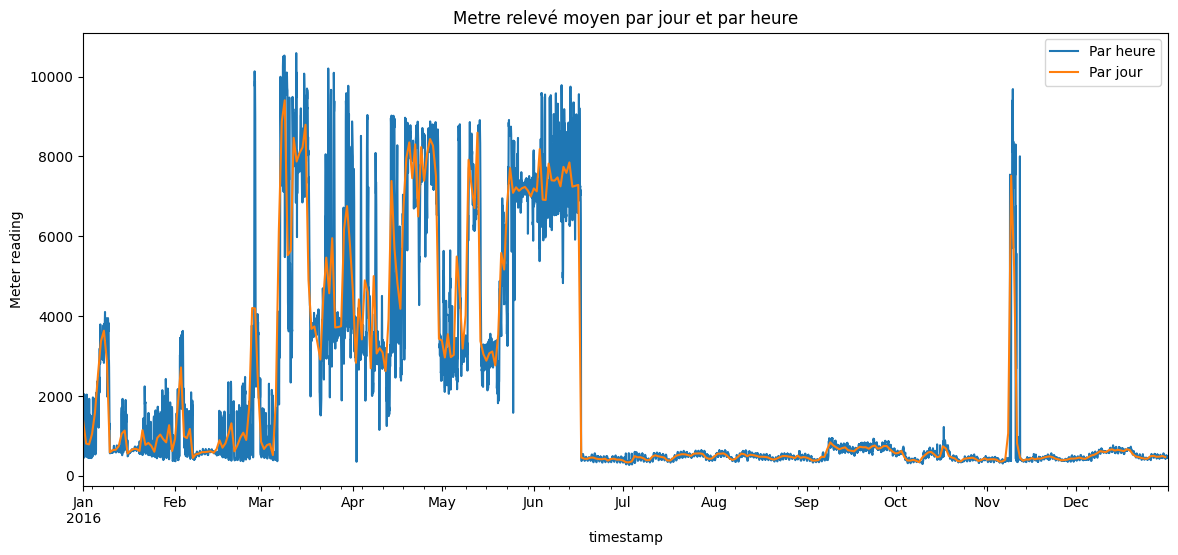

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
train_m[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

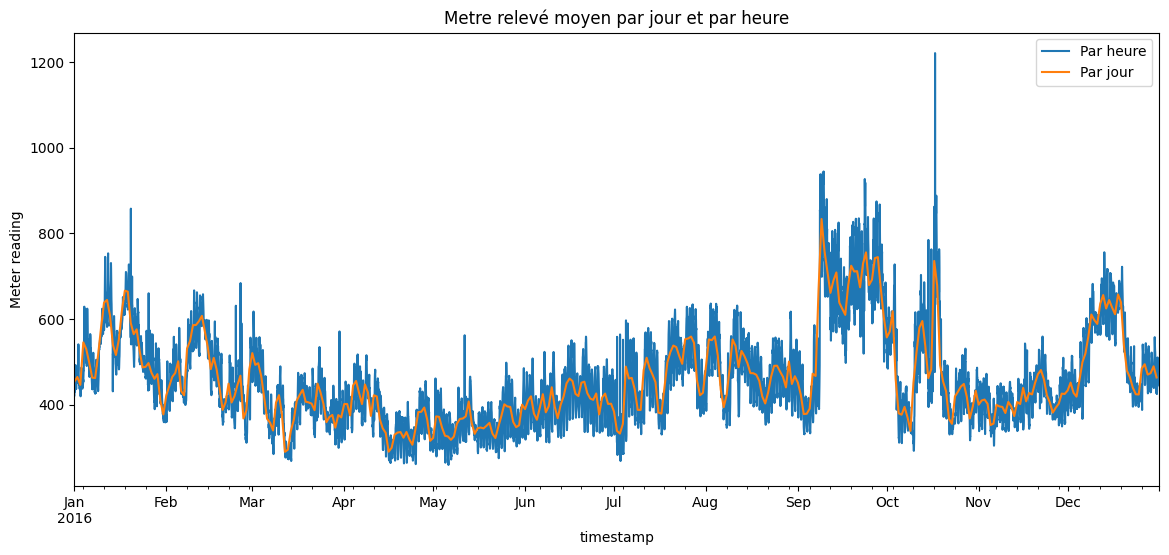

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6),dpi=100)
new_train=train_m[train_m['building_id'] != 1099]
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()['meter_reading'].plot(ax=axes, label='Par heure').set_ylabel('Meter reading');
new_train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').mean()['meter_reading'].plot(ax=axes, label='Par jour').set_ylabel('Meter reading');
axes.set_title('Metre relevé moyen par jour et par heure');
axes.legend();
plt.show()

In [97]:
new_test=test_m
new_test

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.796875,4.0,11.703125,NaN,1021.5,100.0,3.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remplacement NA

In [43]:
for i in list_pu:
    print(i)
    print(new_train[new_train['primary_use']==i].isnull().sum()*100/new_train[new_train['primary_use']==i].shape[0])
    print("")

Education
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            50.276769
floor_count            0.000000
air_temperature        0.532540
cloud_coverage        45.090267
dew_temperature        0.560719
precip_depth_1_hr     24.329787
sea_level_pressure     7.494804
wind_direction         8.564535
wind_speed             0.817790
dtype: float64

Office
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            75.512803
floor_count            0.000000
air_temperature        0.377577
cloud_coverage        43.368737
dew_temperature        0.383630
precip_depth_1_hr     14.160825
sea_level_pressure     4.246502
wind_di

`Services`, `Food sales and service`, `Religious worship` n'ont aucune donnée pour la variable `floor_count`. Nous allons d'abord combler ce qu'il manque dans les autres catégories par la moyenne. 

In [68]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.955237
floor_count            1.202909
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [58]:
import statistics
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)        


In [60]:
for i in range(len(list_pu)):
    if (list_pu[i]!="Services") & (list_pu[i]!="Food sales and service") & (list_pu[i]!="Religious worship") :
        new_train.loc[new_train.primary_use==list_pu[i],['floor_count']]=new_train[new_train['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['floor_count']]=new_test[new_test['primary_use']==list_pu[i]]['floor_count'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [69]:
list_sid_mean=[]
list_sid_mean_test=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)
        
for i in list_sid:
    temp=new_test[new_test['site_id']==i]['floor_count'].dropna()
    if (len(temp)>0):
        list_sid_mean_test.append(statistics.mean(temp))
    else :
        list_sid_mean_test.append(0)

In [71]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['floor_count']]=new_train[new_train['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean[i])
    new_test.loc[new_test.site_id==list_sid[i],['floor_count']]=new_test[new_test['site_id']==list_sid[i]]['floor_count'].fillna(list_sid_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [72]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built            59.955237
floor_count            0.000000
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

C'est bon pour `floor_count`, au tour de `year_built`

In [73]:
list_pu_mean=[]
list_pu_mean_test=[]
for i in list_pu:
    temp=new_train[new_train['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean.append(statistics.mean(temp))
    else :
        list_pu_mean.append(0)
        
for i in list_pu:
    temp=new_test[new_test['primary_use']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_pu_mean_test.append(statistics.mean(temp))
    else :
        list_pu_mean_test.append(0)

In [76]:
for i in range(len(list_pu)):
    if list_pu[i]!="Services":
        new_train.loc[new_train.primary_use==list_pu[i],['year_built']]=new_train[new_train['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean[i])
        new_test.loc[new_test.primary_use==list_pu[i],['year_built']]=new_test[new_test['primary_use']==list_pu[i]]['year_built'].fillna(list_pu_mean_test[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [ ]:
new_train.isnull().sum()*100/new_train.shape[0]

In [78]:
list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['year_built'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

In [79]:
for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['year_built']]=new_train[new_train['site_id']==list_sid[i]]['year_built'].fillna(list_sid_mean[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,NaN,-5.601562,-1.0,1008.5,180.0,8.796875


In [80]:
new_train.isnull().sum()*100/new_train.shape[0]

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.478520
cloud_coverage        43.650529
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

Pour les infos météo, on se base seulement selon le site. Se baser sur `primary_use` n'aurait pas de sens pour ce type de donnée.

In [81]:
for i in list_sid:
    print(i)
    print(new_train[new_train['site_id']==i].isnull().sum()*100/new_train[new_train['site_id']==i].shape[0])
    print("")

13
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.022790
cloud_coverage        48.947571
dew_temperature        0.022790
precip_depth_1_hr      0.147688
sea_level_pressure     1.377999
wind_direction         2.481296
wind_speed             0.022790
dtype: float64

9
building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.102563
cloud_coverage        39.411560
dew_temperature        0.125330
precip_depth_1_hr      0.125218
sea_level_pressure     2.770252
wind_direction     

In [84]:
#cloud coverage
#site id 7, 11 n'ont aucune donnée

list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['cloud_coverage'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 7) & (list_sid[i] != 11):
        new_train.loc[new_train.site_id==list_sid[i],['cloud_coverage']]=new_train[new_train['site_id']==list_sid[i]]['cloud_coverage'].fillna(list_sid_mean[i])
new_train

13
9
2
14
3
15
0
5
4
6
8
1
10
12


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.000000,20.000000,NaN,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,1.116211,-5.601562,-1.0,1008.5,180.0,8.796875


In [85]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 2% de cloud_coverage inconnu

building_id            0.000000
meter                  0.000000
timestamp              0.000000
meter_reading          0.000000
site_id                0.000000
primary_use            0.000000
square_feet            0.000000
year_built             0.000000
floor_count            0.000000
air_temperature        0.478520
cloud_coverage         2.406808
dew_temperature        0.495759
precip_depth_1_hr     18.560738
sea_level_pressure     6.096616
wind_direction         7.171867
wind_speed             0.711299
dtype: float64

In [86]:
#precip_depth_1_hr
#12, 5, 1 n'ont pas de donnée

list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['precip_depth_1_hr'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    if (list_sid[i] != 12) & (list_sid[i] != 5) & (list_sid[i] != 1):
        new_train.loc[new_train.site_id==list_sid[i],['precip_depth_1_hr']]=new_train[new_train['site_id']==list_sid[i]]['precip_depth_1_hr'].fillna(list_sid_mean[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875


In [87]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 8% d'inconnu pour precip_depth_1_hr

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.478520
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    6.096616
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [88]:
#sea_lever_pressure
#le site 5 n'a aucune donnée

list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['sea_level_pressure'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    if list_sid[i] != 5:
        new_train.loc[new_train.site_id==list_sid[i],['sea_level_pressure']]=new_train[new_train['site_id']==list_sid[i]]['sea_level_pressure'].fillna(list_sid_mean[i])
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,6.000000,20.000000,1.389648,1019.5,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,1.116211,-5.601562,-1.000000,1008.5,180.0,8.796875


In [89]:
new_train.isnull().sum()*100/new_train.shape[0] #il reste 3.8% d'inconnu pour sea_level_pressure

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.478520
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [90]:
#air_temperature
list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['air_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['air_temperature']]=new_train[new_train['site_id']==list_sid[i]]['air_temperature'].fillna(list_sid_mean[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.495759
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [91]:
#dew_temperature
list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['dew_temperature'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['dew_temperature']]=new_train[new_train['site_id']==list_sid[i]]['dew_temperature'].fillna(list_sid_mean[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        7.171867
wind_speed            0.711299
dtype: float64

In [92]:
#wind_direction
list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_direction'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_direction']]=new_train[new_train['site_id']==list_sid[i]]['wind_direction'].fillna(list_sid_mean[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        0.000000
wind_speed            0.711299
dtype: float64

In [93]:
#wind_speed
list_sid_mean=[]
for i in list_sid:
    temp=new_train[new_train['site_id']==i]['wind_speed'].dropna()
    if (len(temp)>0):
        list_sid_mean.append(statistics.mean(temp))
    else :
        list_sid_mean.append(0)

for i in range(len(list_sid)):
    new_train.loc[new_train.site_id==list_sid[i],['wind_speed']]=new_train[new_train['site_id']==list_sid[i]]['wind_speed'].fillna(list_sid_mean[i])

new_train.isnull().sum()*100/new_train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.000000
floor_count           0.000000
air_temperature       0.000000
cloud_coverage        2.406808
dew_temperature       0.000000
precip_depth_1_hr     8.174068
sea_level_pressure    3.870459
wind_direction        0.000000
wind_speed            0.000000
dtype: float64

Pour bien terminer le travail, et finir de remplir les derniers NA, il faudrait comparer les données météo pour retrouver les villes des différents sites et récupérer les données. On pourrait même remplacer les données moyennes ajoutées aux données météo par les valeurs réelles trouvées.

In [95]:
#FE
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

new_train['date'] = new_train.timestamp.dt.date
new_train ['heure'] = new_train.timestamp.dt.hour
new_train ['mois'] = new_train.timestamp.dt.month
new_train ['joursemaine'] = new_train.timestamp.dt.dayofweek

cal = calendar()
vac = cal.holidays(start=new_train.timestamp.min(), end=new_train.timestamp.max())
new_train['EstVac'] = new_train['timestamp'].isin(vac)

In [96]:
new_train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,...,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,date,heure,mois,joursemaine,EstVac
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,5.246094,25.000000,...,20.000000,1.389648,1019.5,0.0,0.000000,2016-01-01,0,1,4,True
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,5.246094,25.000000,...,20.000000,1.389648,1019.5,0.0,0.000000,2016-01-01,0,1,4,True
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,5.246094,25.000000,...,20.000000,1.389648,1019.5,0.0,0.000000,2016-01-01,0,1,4,True
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,5.246094,25.000000,...,20.000000,1.389648,1019.5,0.0,0.000000,2016-01-01,0,1,4,True
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,5.246094,25.000000,...,20.000000,1.389648,1019.5,0.0,0.000000,2016-01-01,0,1,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,2.093750,1.700195,...,-5.601562,-1.000000,1008.5,180.0,8.796875,2016-12-31,23,12,5,False
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,1965.0,5.246094,1.700195,...,-5.601562,-1.000000,1008.5,180.0,8.796875,2016-12-31,23,12,5,False
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,2.093750,1.700195,...,-5.601562,-1.000000,1008.5,180.0,8.796875,2016-12-31,23,12,5,False
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,6.382812,1.700195,...,-5.601562,-1.000000,1008.5,180.0,8.796875,2016-12-31,23,12,5,False


# <a id='6'>6. Model Training</a>

In [ ]:
%%time
from sklearn.model_selection import GridSearchCV #, train_test_split,TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor

y_train = train_m['meter_reading']

# my_tree = DecisionTreeRegressor()

# MSE = make_scorer(mean_squared_error)

In [ ]:
test_m

In [ ]:
# param_grid = {'splitter' : ['best', 'random'],'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson']}
# model = GridSearchCV(my_tree, param_grid, scoring=MSE)

In [ ]:
train_df = train_df.drop('timestamp', axis = 1)

test_df = test_df.drop('timestamp', axis = 1)

In [ ]:
# predicted = model.predict(test_df)

# print('Best Parameters found for MSE : ',model.best_params_)
# print('Train Score : ',model.score(train_m.drop('meter_reading') , y_train))


from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from math import sqrt

X = train_df
X_test = test_df
y = y_train

reg = tree.DecisionTreeRegressor(max_leaf_nodes=50)
reg = reg.fit(X,y)
y_train_predict_tree=reg.predict(X)

print("La RMSE de l'arbre de régression de train",sqrt(mean_squared_error(y, y_train_predict_tree)))

In [ ]:
print("La RMSLE de l'arbre de régression de train",sqrt(mean_squared_log_error(y, y_train_predict_tree)))

Now that we have tuned the model parameters and have an idea of model performance. We will fit on the entire training dataset so we have as much information as possible for the final test set prediction.

# <a id='7'>7. Model Predictions and Kaggle Submission</a>

In [ ]:
#obtention des prédictions et du fichier à évaluer 
y_test_predict_tree=reg.predict(X_test)

my_submission = pd.DataFrame({'row_id': test_m.row_id, 'meter_reading': y_test_predict_tree})
my_submission.to_csv('submission_tree_f.csv', index=False)